# FIFA player data cleaning

This notebook will process the FIFA player data CSVs and clean/modify so they are ready for analysis & learning.

In [3]:
import pandas as pd
import numpy as np
import re

The player list below can be altered to run the subset of files interested.

In [4]:
player_file_list = ['players_15.csv', 'players_16.csv', 'players_17.csv', 'players_18.csv', 'players_19.csv', 'players_20.csv']
#player_file_list = ['players_19.csv']
#player_file_list = ['players_19.csv']
input_directory = 'data/'
output_directory = 'cleaned_data/'

In [3]:
target_cols = set()

## cleandata_number_values
This function will take a DataFrame and correct the numbers for statistics that contain +/- within the text. These were seemingly used to identify deltas, but will prohit the data from being analyzed since it's a string.

In [4]:
def cleandata_number_values(df):
    
    df = df.copy(deep=True)
    
    column_number_fix_list = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', \
                          'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', \
                          'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', \
                          'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', \
                          'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', \
                          'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', \
                          'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', \
                          'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
        
    # fix the +/- within number cols
    pattern = r'^[\d]+'
    for index, row in df.iterrows():
        for column in column_number_fix_list:
            value = row[column]
            if type(value) is str:
                match = re.match(pattern, value)
                if match:
                    value = int(match[0])
                    df.at[index, column] = value
                    
    return df

## cleandata_classes
This function will take the interested predictors that will be used, that also happen to be categorized. This will make the necessary changes where 2-category will go to a binary predictor and 3+ category will be converted into separate columns.

In [5]:
def cleandata_classes(df):
    
    df = df.copy(deep=True)
    
    # make team_position binary
    team_pos_col = 'team_position'
    for position in df[team_pos_col].unique():
        print(f'Processing team position: {position}...')
        col_name = team_pos_col + '_' + position.lower()
        df[col_name] = 1 * (df[team_pos_col] == position)
        
        target_cols.add(col_name)
        print(f'Added binary column: {col_name}')
        
    if team_pos_col in target_cols:
        target_cols.remove(team_pos_col)
    print('Removed team_position.')
    
    # get player_positions values
    player_pos_col = 'player_positions'
    player_pos_values = set()
    for position in df[player_pos_col].unique():
        pos_values = position.split(', ')
        for pos_value in pos_values:
            player_pos_values.add(pos_value)
            
    # make player_positions binary
    for player_pos_value in player_pos_values:
        print(f'Processing player position: {player_pos_value}...')
        col_name = player_pos_col + '_' + player_pos_value.lower()
        df[col_name] = 0
    
        for index, row in df.iterrows():
            if player_pos_value in row[player_pos_col]:
                df.loc[index, col_name] = 1
        
        target_cols.add(col_name)
        print(f'Added column: {col_name}')
    if player_pos_col in target_cols:
        target_cols.remove(player_pos_col)
    print('Removed player_positions.')
    
    # set preferred foot
    preferred_foot_col = 'preferred_foot'
    preferred_foot_col_new = 'preferred_foot_bin'
    df[preferred_foot_col_new] = 1 * (df[preferred_foot_col] == 'Left')
    target_cols.add(preferred_foot_col_new)
    if preferred_foot_col in target_cols:
        target_cols.remove(preferred_foot_col)
    print('Removed preferred_foot.')
        
    return df


## cleandata_check_na

This is an initial scan to make sure incomplete rows are removed (much be a very small number) and any other NaN values are identified. If there are other NaN values, it will be flagged here, which should be actioned prior to proceeding.

In [6]:
def cleandata_check_na(df):
    
    df = df.copy(deep=True)
    
    # drop empty rows for positions
    df = df.dropna(subset=['team_position', 'player_positions', 'preferred_foot'])
    
    # check for other NaNs values
    for target_col in target_cols:
        for val in np.array(df[target_col].unique()):
            if np.nan == val:
                print(f'Column {target_col} has NaN in it.')
                
    return df

## cleandata_align_goalkeeper_data

This will assure any remaining holes are filled, which should apply almost completely (if not completely) to the differences in how non-goalkeepers and goalkeepers stats are tracked.

The goalkeeper position has a different set of predictors, but in order to apply them in the same way, the holes will be filled with zeros and the necessary model will be created to handle these variations.

In [7]:
def cleandata_align_goalkeeper_data(df):
    
    df = df.copy(deep=True)
    
    # fill in the gaps for goalkeepers & inverse as zeros
    for index, row in df.iterrows():
        for col in target_cols:
            if pd.isnull(row[col]) or row[col] == '':
                df.loc[index, col] = 0
                
    return df

## clean_file_data

This is the main data cleaning function, which will call the necessary functions above. You provide it a raw DataFrame, it will copy, clean, and then return the new DataFrame.

In [8]:
def clean_file_data(df):    
    
    # check/fix NaN
    print('Checking & fixing NaN values...')
    df = cleandata_check_na(df)
    
    # fix the +/- within number cols
    print('Fixing row +/- values...')
    df = cleandata_number_values(df)
                    
    # split position columns
    print('Fixing class columns (e.g. positions)...')
    df = cleandata_classes(df)
    
    # fill any gaps
    print('Filling any remaining holes, such as with goalkeepers...')
    df = cleandata_align_goalkeeper_data(df)
    
    return df

## Main logic for the cleaning

In [9]:
for file_name in player_file_list:
    
    target_cols = {'age', 'height_cm', 'weight_kg', 'player_positions', 'preferred_foot', 'international_reputation', \
                   'weak_foot', 'skill_moves', 'team_position', 'pace', \
                   'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', \
                   'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', \
                   'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', \
                   'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', \
                   'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', \
                   'mentality_vision', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', \
                   'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', \
                   'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', \
                   'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'}
    
    input_path = input_directory + file_name
    df = pd.read_csv(input_path)
    
    df = clean_file_data(df)
    
    print('\nColumn values & types after cleaning:')
    for target_col in target_cols:
        print(f'   {target_col}: {df[target_col].dtypes}')
    
    output_path = output_directory + file_name
    df.to_csv(output_path)
    print('\nCleaned file written.')
    
    with open(output_directory + 'player_data_cols.csv', 'w') as outfile:
        for target_col in target_cols:
            outfile.write(f'{target_col}\n')
    print('\nWrote target player columns file.')

Checking & fixing NaN values...
Fixing row +/- values...
Fixing class columns (e.g. positions)...
Processing team position: CF...
Added binary column: team_position_cf
Processing team position: LW...
Added binary column: team_position_lw
Processing team position: SUB...
Added binary column: team_position_sub
Processing team position: ST...
Added binary column: team_position_st
Processing team position: GK...
Added binary column: team_position_gk
Processing team position: RES...
Added binary column: team_position_res
Processing team position: LM...
Added binary column: team_position_lm
Processing team position: RS...
Added binary column: team_position_rs
Processing team position: RW...
Added binary column: team_position_rw
Processing team position: LS...
Added binary column: team_position_ls
Processing team position: RCM...
Added binary column: team_position_rcm
Processing team position: LCB...
Added binary column: team_position_lcb
Processing team position: CAM...
Added binary column: 

## Datatype verification

This method is to be used after successfully writing the cleaned files. This will re-read the specified file and then pull the columns and datatypes. This is used to verify all columns needed are present and datatypes are numbers (ints or floats).

In [8]:
target_cols = []
with open('cleaned_data/player_data_cols.csv') as cols_file:
    for col in cols_file:
        col = col.replace('\n', '')
        target_cols.append(col)

In [9]:
df = pd.read_csv('cleaned_data/players_19.csv')
print('\nColumn values & types after cleaning:')
for target_col in target_cols:
    is_error_str = ''
    if df[target_col].dtypes == 'object':
        is_error_str = '[ERROR] '
    print(f'{is_error_str}   {target_col}: {df[target_col].dtypes}')


Column values & types after cleaning:
   team_position_rm: int64
   attacking_crossing: int64
   movement_balance: int64
   team_position_rf: int64
   mentality_vision: int64
   goalkeeping_diving: int64
   player_positions_lm: int64
   team_position_rs: int64
   pace: float64
   dribbling: float64
   skill_dribbling: int64
   attacking_finishing: int64
   team_position_rdm: int64
   player_positions_rwb: int64
   team_position_rcb: int64
   gk_positioning: float64
   skill_fk_accuracy: int64
   goalkeeping_kicking: int64
   team_position_st: int64
   player_positions_lwb: int64
   player_positions_cm: int64
   player_positions_cf: int64
   team_position_ldm: int64
   team_position_lm: int64
   physic: float64
   weak_foot: int64
   defending_sliding_tackle: int64
   team_position_gk: int64
   team_position_cam: int64
   team_position_lf: int64
   mentality_aggression: int64
   skill_moves: int64
   skill_curve: int64
   passing: float64
   player_positions_rb: int64
   team_position_

/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


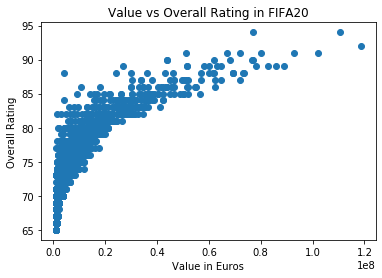

In [10]:
import matplotlib.pyplot as plt

df_filter = df.loc[df['value_eur'] > 1000000]
plt.scatter(df_filter['value_eur'], df_filter['overall'])
plt.xlabel('Value in Euros')
plt.ylabel('Overall Rating')
plt.title('Value vs Overall Rating in FIFA20')
plt.show()